# DDoS hyökkäysten tunnistaminen tietoliikenteestä


Tässä työssä kokeillaan kolmea eri koneoppimisen mallia DDoS hyökkäysten tunnistamiseen New Brunswick'in yliopiston keräämän DDoS hyökkäys datan avulla

Työssä käytetty data löytyy osoitteesta: https://www.kaggle.com/datasets/solarmainframe/ids-intrusion-csv/


## Käytetyt kirjastot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.layers import Reshape, Input, Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow as tf
from keras import regularizers
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


## Data

In [106]:
df = pd.read_csv('data/02-14-2018.csv')
pd.set_option('display.max_columns', None)

In [108]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.632086e+07,139.300036,56320958,56320761,112641719,5.632086e+07,139.300036,56320958,56320761,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.00,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026633,5.632073e+07,114.551299,56320814,56320652,112641466,5.632073e+07,114.551299,56320814,56320652,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026633,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.00,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.026634,5.631931e+07,301.934596,56319525,56319098,112638623,5.631931e+07,301.934596,56319525,56319098,0,0.000000,0.000000,0,0,0,0,0,0,0,0,0.026634,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0.00,0.000000,0.000000,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,82.600000,196.741237,976,0,227.300000,371.677892,544.161528,3.873587,2.689152e+05,247443.778966,673900,22,6453966,4.609976e+05,123109.423588,673900,229740,5637902,626433.555556,455082.214224,1167293,554,0,0,0,0,488,328,2.324152,1.549435,0,976,135.076923,277.834760,77192.153846,0,0,0,1,0,0,0,0,0,140.48,82.600000,227.300000,0,0,0,0,0,0,15,1239,10,2273,65535,233,6,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,81.642857,203.745545,976,0,200.818182,362.249864,380.733175,2.839597,3.668361e+05,511356.609733,1928102,21,8804066,6.772358e+05,532416.970959,1928102,246924,7715481,771548.100000,755543.082717,2174893,90,0,0,0,0,456,360,1.590174,1.249423,0,976,128.923077,279.763032,78267.353846,0,0,0,1,0,0,0,0,0,134.08,81.642857,200.818182,0,0,0,0,0,0,14,1143,11,2209,5808,233,6,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [559]:
df.describe()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,7.618860e+05,761886.000000,761886.000000,7.618860e+05,7.618860e+05,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,761886.000000,761886.000000,761886.000000,7.618860e+05,7.618860e+05,761886.000000,761886.000000,761886.000000,761886.000000,7.618860e+05,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,7.618860e+05,761886.000000,7.618860e+05,761886.000000,761886.000000,761886.000000,761886.000000,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,7.618860e+05,761886.0
mean,3.461179e+06,6.162573,6.783372,4.890796e+02,3.337454e+03,181.423958,6.415947,36.819643,50.044819,329.117283,15.407316,81.848876,107.337233,1.470721e+05,3.557608e+05,1.032783e+06,2.471999e+06,6.350667e+06,-3.050886e+06,3.214052e+06,1.180084e+06,2.511777e+06,6.177742e+06,-3.020463e+06,4.452616e+06,3.721828e+05,4.775607e+05,1.394194e+06,6.469875e+04,0.019273,165.623944,172.833679,1.838038e+05,1.719570e+05,6.367014,333.037439,56.853844,90.120289,2.786841e+04,0.002569,0.019273,0.036198,0.586370,0.252559,0.147786,0.036197,0.707137,63.520436,36.819643,81.848876,6.162573,4.890796e+02,6.783372,3.337454e+03,12737.880038,5890.058920,3.105887,26.087226,4.142609e+04,1.669506e+04,6.930086e+04,3.225429e+04,2.966249e+06,9.581125e+05,5.287057e+06,1.673204e+06,0.5
std,1.478369e+09,33.369178,84.948370,1.844990e+04,1.223761e+05,300.470870,17.532638,54.011480,84.868272,489.998004,41.542274,144.064647,177.686452,2.746470e+06,6.098148e+05,3.908837e+08,8.602625e+08,1.795043e+09,1.924901e+09,1.478365e+09,3.908856e+08,8.602634e+08,1.795042e+09,1.924902e+09,1.978876e+07,1.943312e+06,2.304813e+06,7.023567e+06,1.378361e+06,0.137484,818.968068,1709.366820,3.272367e+05,2.996678e+05,16.989221,501.831767,93.286380,140.523186,1.262694e+05,0.050617,0.137484,0.186783,0.492484,0.434480,0.354888,0.186780,0.540530,97.695045,54.011480,144.064647,33.369178,1.844990e+04,84.948370,1.223761e+05,13270.349154,17888.519976,6.033974,11.211341,5.105845e+05,1.982243e+05,6.550276e+05,4.906669e+05,6.351911e+08,4.481470e+08,1.785660e+09,1.992825e+07,0.5
min,-9.190110e+11,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-1.029761e-03,-3.407010e+11,0.000000e+00,-1.594380e+11,-9.435640e+11,-9.190110e+11,-3.407010e+11,0.000000e+00,-1.594380e+11,-9.435640e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,-1.000000,-1.000000,0.000000,0.000000,0.000000e+00,0.00000

In [560]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761886 entries, 0 to 761885
Data columns (total 67 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow Duration      761886 non-null  int64  
 1   Tot Fwd Pkts       761886 non-null  int64  
 2   Tot Bwd Pkts       761886 non-null  int64  
 3   TotLen Fwd Pkts    761886 non-null  int64  
 4   TotLen Bwd Pkts    761886 non-null  int64  
 5   Fwd Pkt Len Max    761886 non-null  int64  
 6   Fwd Pkt Len Min    761886 non-null  int64  
 7   Fwd Pkt Len Mean   761886 non-null  float64
 8   Fwd Pkt Len Std    761886 non-null  float64
 9   Bwd Pkt Len Max    761886 non-null  int64  
 10  Bwd Pkt Len Min    761886 non-null  int64  
 11  Bwd Pkt Len Mean   761886 non-null  float64
 12  Bwd Pkt Len Std    761886 non-null  float64
 13  Flow Byts/s        761886 non-null  float64
 14  Flow Pkts/s        761886 non-null  float64
 15  Flow IAT Mean      761886 non-null  float64
 16  Fl

# Datan esikäsittely

In [109]:
# Tiputetaan tarpeettomat kolumnit (sisältävät pelkästään 0 arvoja)
df = df.drop(columns=['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg'])

In [110]:
# Aikaleimoista ei ole hyöytyä hyökkäysten tunnistamisessa, poistetaan ne
df.drop(columns=['Timestamp'], inplace=True)

In [111]:
# Portti ja protokolla eivät myöskään hyödytä, poistetaan ne
df.drop(columns=['Dst Port', 'Protocol'], inplace=True)

In [112]:
# Poistetaan äärettömät arvot
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [113]:
# Käytetään virheetöntä dataa, poistetaan puutteelliset rivit
df.dropna(inplace=True)

In [114]:
# Katsotaan kuinka paljon hyökkäyksiä datasetistä löytyy
df["Label"].value_counts()

Label
Benign            663808
FTP-BruteForce    193354
SSH-Bruteforce    187589
Name: count, dtype: int64

In [115]:
# Yhdistetään hyökkäystyypit ja luokitellaan ne pelkästään hyökkäyksinä
df.replace(to_replace=["FTP-BruteForce", "SSH-Bruteforce"], value="Attack", inplace=True)

In [116]:
df["Label"].value_counts()

Label
Benign    663808
Attack    380943
Name: count, dtype: int64

In [117]:
# Muutetaan datan tyypit numeeriseen muotoon
df.replace(to_replace="Benign", value=0, inplace=True)
df.replace(to_replace="Attack", value=1, inplace=True)

In [118]:
# Koska data on vinoutunut, tasapainotetaan data
subset_bening = df[df['Label'] == 0]
subset_attack = df[df['Label'] == 1]

min_occurrences = min(len(subset_bening), len(subset_attack))

new_df = pd.concat([subset_bening.head(min_occurrences), subset_attack.head(min_occurrences)])

df = new_df.sample(frac=1).reset_index(drop=True)

df["Label"].value_counts()

Label
1    380943
0    380943
Name: count, dtype: int64

In [240]:
df.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.00000,0.000000,333333.333333,6.000000,0.000000,6,6,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,32,32,166666.666667,166666.666667,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,1,0,1,0.000000,0.000000,0.000000,1,0,1,0,241,230,0,32,0.0,0.0,0,0,0.0,0.0,0,0,1
1,38649,1,1,33,127,33,33,33.000000,0.000000,127,127,127.000000,0.00000,4139.822505,51.747781,38649.000000,0.000000,38649,38649,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,8,8,25.873891,25.873891,33,127,64.333333,54.270925,2945.333333,0,0,0,0,0,0,0,1,96.500000,33.000000,127.000000,1,33,1,127,-1,-1,0,8,0.0,0.0,0,0,0.0,0.0,0,0,0
2,42401,2,2,90,122,45,45,45.000000,0.000000,61,61,61.000000,0.00000,4999.882078,94.337398,14133.666667,23746.743278,41554,381,41935,41935.000000,0.000000,41935,41935,42020,42020.000000,0.000000,42020,42020,0,16,16,47.168699,47.168699,45,61,51.400000,8.763561,76.800000,0,0,0,0,0,0,0,1,64.250000,45.000000,61.000000,2,90,2,122,-1,-1,1,8,0.0,0.0,0,0,0.0,0.0,0,0,0
3,361262,24,22,1928,2665,640,0,80.333333,133.958678,976,0,121.136364,258.64156,12713.764525,127.331410,8028.044444,15358.738339,55436,3,359857,15645.956522,23322.540524,78644,294,361255,17202.619048,27919.251133,92337,12,0,776,712,66.433779,60.897631,0,976,97.723404,200.347817,40139.247919,0,0,0,1,0,0,0,0,99.847826,80.333333,121.136364,24,1928,22,2665,26883,230,16,32,0.0,0.0,0,0,0.0,0.0,0,0,1
4,2,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.00000,0.000000,1000000.000000,2.000000,0.000000,2,2,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,40,20,500000.000000,500000.000000,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,1,0.000000,0.000000,0.000000,1,0,1,0,26883,0,0,40,0.0,0.0,0,0,0.0,0.0,0,0,1


In [496]:
# Jaetaan data harjoitus- ja testidataksi
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [497]:
# Luodaan min max scaler jolla voidaan normalisoida data 0-1 välillä oleviksi arvoiksi
min_max_scaler = MinMaxScaler().fit(train[train.drop(columns=["Label"]).columns])
train[train.drop(columns=["Label"]).columns] = min_max_scaler.transform(train[train.drop(columns=["Label"]).columns])
test[test.drop(columns=["Label"]).columns] = min_max_scaler.transform(test[test.drop(columns=["Label"]).columns])

In [498]:
# Erotetaan luokittelu harjoitus ja testidatasta
y_train = np.array(train.pop("Label"))
X_train = train.values

y_test = np.array(test.pop("Label"))
X_test = test.values

In [499]:
print(X_train.shape)
print(y_train.shape)

(533320, 66)
(533320,)


# Tulostentarkastelufunktiot

Ennen kuin testataan eri malleja, luodaan funktioita joiden avulla voidaan tarkastella tuloksia

In [500]:
# Funktio luo sekaannusmatriisin (confusion matrix) tuloksista
def create_confusion_matrix(y_test, result):
    conf_matrix = confusion_matrix(y_test, result)
    print("Confusion Matrix:")
    
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [506]:
# Funktio laskee tulosten perusteella precision_scoren, recall_scoren, ja f1_scoren
def calculate_results(y_test, result):
    conf_matrix = confusion_matrix(y_test, result)
    true_negative, false_positive, false_negative, true_positive = conf_matrix.ravel()
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Kuinka luottavasti malli tunnistaa positiiviset tapaukset
    print(f"Precision: {precision:.6f}")
    # Kuinka suuren osuuden todellisista positiivisista tapauksista malli onnistui tunnistamaan
    print(f"Recall: {recall:.6f}")
    # Keskiarvo precisionista ja recallista
    print(f"F1 Score: {f1:.6f}")
    

In [523]:
# Luo käyrän tappioiden määrän kehityksestä jokaisella Epochilla
def create_loss_curves(history):
    plt.figure(figsize=[8,6])
    train_line = plt.plot(history.history['loss'],'r',linewidth=3.0)
    val_line  = plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
    plt.xlabel('Epochs ',fontsize=12)
    plt.ylabel('Loss',fontsize=12)
    plt.title('Loss Curves',fontsize=12)
    plt.setp(train_line, color='r', alpha=0.75)
    plt.setp(val_line, color='b', alpha=0.75)

    plt.show()

In [524]:
# Luo käyrän tarkkuuden kehityksestä jokaisella Epochilla
def create_accuracy_curves(history):
    plt.figure(figsize=[8,6])
    train_line = plt.plot(history.history['accuracy'],'r',linewidth=3.0)
    val_line  = plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
    plt.xlabel('Epochs ',fontsize=12)
    plt.ylabel('Accuracy',fontsize=12)
    plt.title('Accuracy Curves',fontsize=12)
    plt.setp(train_line, color='r', alpha=0.75)
    plt.setp(val_line, color='b', alpha=0.75)
    
    plt.show()

# Multilayer Perceptron

Yksi DDoS hyökkäysten tunnistamisessa tehokkaaksi todettu koneoppimismenetelmä on Multilayer Perceptron (MLP) (Ahmed et al., 2023).

MLP on eteenpäinsyöttävä (feedforward) keinotekoinen neuroverkko. Se käyttää koulutuksessa takaisinkytkentää (backpropagation) ja gradienttien laskua (gradient descent)

In [502]:
# Koulutetaan Multilayer Perceptron Classifier 
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [503]:
# Ennustetaan DDoS hyökkäyksiä testidatasta
result = clf.predict(X_test)

Confusion Matrix:


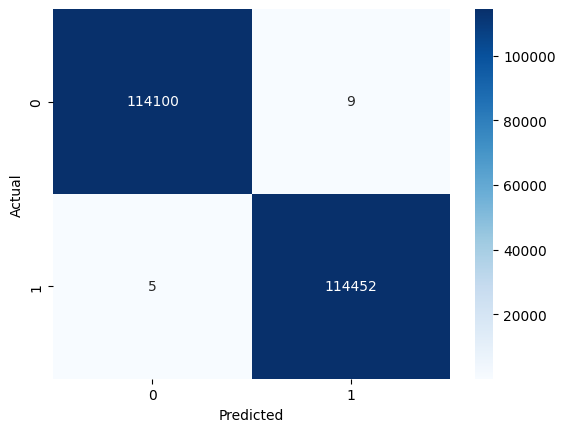

In [504]:
# Luodaan sekaannusmatriisi (confusion matrix) tuloksista
create_confusion_matrix(y_test, result)

In [507]:
# Lasketaan precision_score, recall_score, ja f1_score
calculate_results(y_test, result)

Precision: 0.999921
Recall: 0.999956
F1 Score: 0.998693


### Kokeillaan mallia uudestaan pienemmällä datasetillä ja seurataan mallin koulutusprosessia

In [510]:
y_train_reduced = y_train[0:10000]
X_train_reduced = X_train[0:10000]
y_test_reduced = y_test[0:10000]
X_test_reduced = X_test[0:10000]

In [511]:
# Koulutetaan Multilayer Perceptron Classifier 
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train_reduced, y_train_reduced)


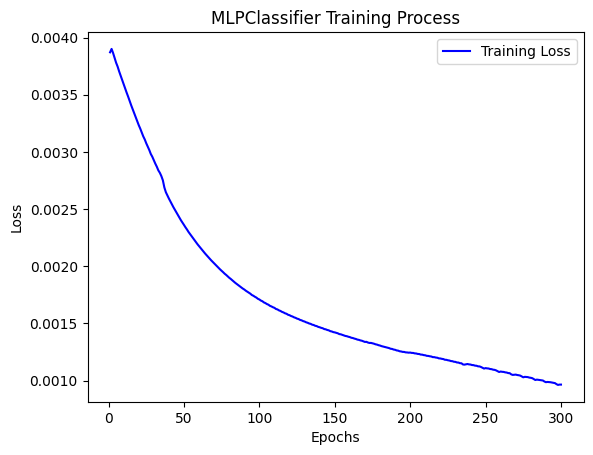

In [512]:
# Luodaan käyrä menetyksien määrän kehityksestä jokaisella Epochilla
train_loss = []
for i in range(clf.max_iter):
    clf.partial_fit(X_train_reduced, y_train_reduced, classes=np.unique(y_test_reduced))
    train_loss.append(clf.loss_)

plt.plot(range(1, clf.max_iter + 1), train_loss, color='blue', label='Training Loss')
plt.title('MLPClassifier Training Process')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [514]:
# Ennustetaan
result = clf.predict(X_test_reduced)

Confusion Matrix:


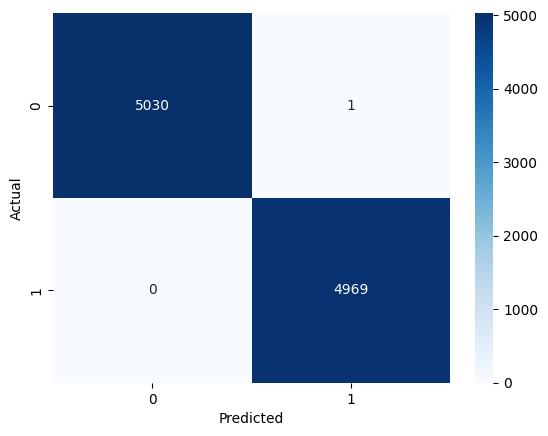

In [515]:
# Luodaan sekaannusmatriisi (confusion matrix) tuloksista
create_confusion_matrix(y_test_reduced, result)

# Konvoluutioneuroverkko


Kokeillaan seuraavaksi DDoS hyökkäysten tunnistamista konvoluutioneuroverkon (CNN) avulla. Konvoluutioneuroverkko on nimensä mukaan neuroverkko, jossa tapahtuu konvoluutio. Konvoluutio-operaatio tapahtuu neuroverkon kerroksissa.

In [516]:
# Jaetaan data harjoitus- ja testidataksi
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [517]:
# Erotetaan luokittelu harjoitus ja testidatasta
y_train = np.array(train.pop("Label"))
X_train = train.values

y_test = np.array(test.pop("Label"))
X_test = test.values

In [518]:
# Muutetaan data CNN:lle sopivaksi standard scalerin avulla
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [519]:
print(X_train.shape)
print(X_test.shape)

(533320, 66, 1)
(228566, 66, 1)


In [520]:
# Pienennetään koulutusaineiston ja testiaineiston kokoa
y_train  = y_train[0:100000]
X_train = X_train[0:100000]

y_test  = y_test[0:100000]
X_test  = X_test[0:100000]

In [521]:
# Rakennetaan cnn malli
# Käytetään aktivoinnissa sigmoidia, koska se soveltuu hyvin binäärimuotoisille luokitteluongelmille

def create_CNN_model():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [522]:
# Koulutetaan malli
model = create_CNN_model()
history = model.fit(X_train,
                    y_train, 
                    epochs=10, 
                    batch_size=250, 
                    validation_data=(X_test, y_test))

Epoch 1/10
400/400 [==============================] - 6s 14ms/step - loss: 0.0246 - accuracy: 0.9942 - val_loss: 0.0037 - val_accuracy: 0.9987
Epoch 2/10
400/400 [==============================] - 6s 14ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0023 - val_accuracy: 0.9996
Epoch 3/10
400/400 [==============================] - 5s 13ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 4/10
400/400 [==============================] - 5s 13ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0024 - val_accuracy: 0.9996
Epoch 5/10
400/400 [==============================] - 6s 14ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 6/10
400/400 [==============================] - 6s 15ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0022 - val_accuracy: 0.9999
Epoch 7/10
400/400 [==============================] - 6s 15ms/step - loss: 9.4131e-04 - accuracy: 0.9998 - val_loss: 0.0023 - val_accuracy: 0.

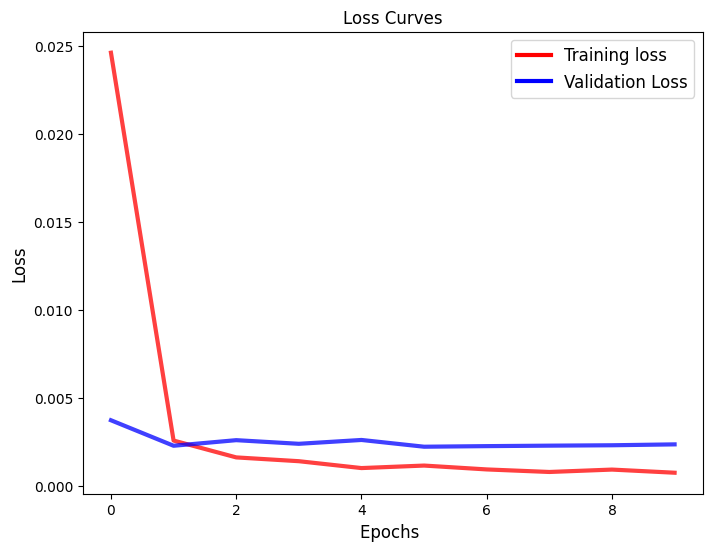

In [526]:
# Luodaan käyrä menetyksien määrän kehityksestä jokaisella Epochilla
create_loss_curves(history)

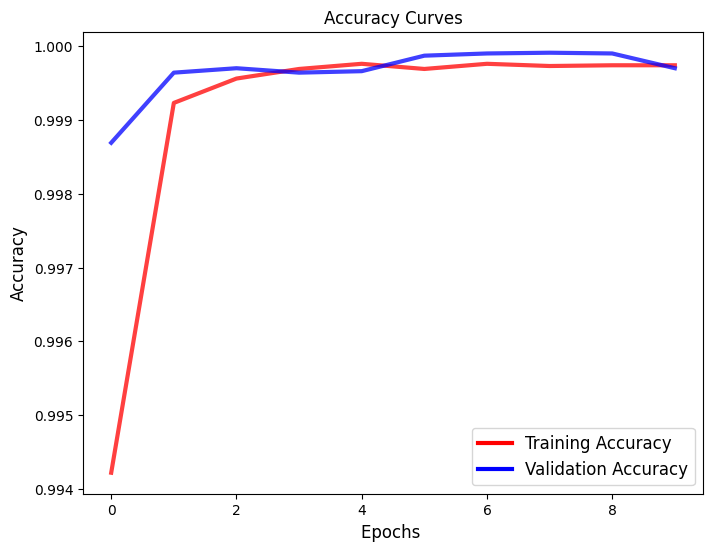

In [527]:
# Luodaan käyrä tarkkuuden kehityksestä jokaisella Epochilla
create_accuracy_curves(history)

In [528]:
# Ennustetaan mallin avulla
result = model.predict(X_test)
result_binary = np.round(result)

accuracy = accuracy_score(y_test, result_binary)
print(f'Accuracy: {accuracy}')

3125/3125 [==============================] - 7s 2ms/step
Accuracy: 0.9997


Confusion Matrix:


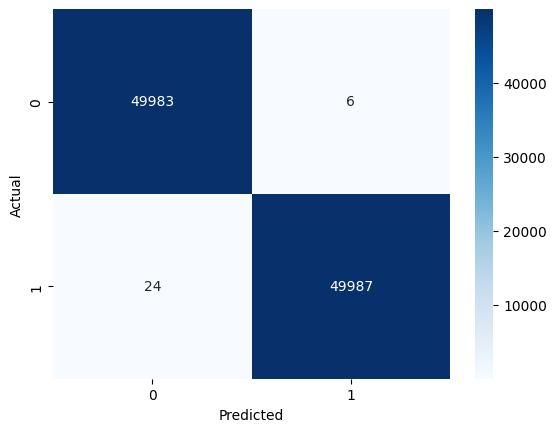

In [529]:
# Luodaan sekaannusmatriisi (confusion matrix) tuloksista
create_confusion_matrix(y_test, result_binary)

In [530]:
# Lasketaan precision_score, recall_score, ja f1_score
calculate_results(y_test, result_binary)

Precision: 0.999880
Recall: 0.999520
F1 Score: 0.998693


# Autoencoder

Kokeillaan vielä DDoS hyökkäysten tunnistamista yksinkertaisen autoencoderin avulla
Autoenkooderi on neuroverkkomalli, joka koostuu enkooderista ja dekooderista.
Mallissa käytetään enkooderia pakkaamaan sisääntulo pienempään muotoon, jonka jälkeen dekooderi yrittää päätellä miltä data näytti ennen sen pakkaamista.
Toisin kuin MLP ja CNN, autoenkooderi käyttää ohjaamatonta oppimista.

In [538]:
# otetaan uudet harjoitus ja testidata setit
train, test = train_test_split(df, test_size=0.3, random_state=55)

In [539]:
# Ajetaan min max scaler uudestaan
min_max_scaler = MinMaxScaler().fit(train[train.drop(columns=["Label"]).columns])
train[train.drop(columns=["Label"]).columns] = min_max_scaler.transform(train[train.drop(columns=["Label"]).columns])
test[test.drop(columns=["Label"]).columns] = min_max_scaler.transform(test[test.drop(columns=["Label"]).columns])

In [540]:
# Pienennetään datan määrää
train = train[0:10000]
test = test[0:10000]

In [541]:
y_train = np.array(train.pop("Label"))
X_train = train.values

y_test = np.array(test.pop("Label"))
X_test = test.values

In [542]:
# luodaan yksinkertainen autoencoder
from keras.optimizers import Adam
def simple_autoencoder():
    model = Sequential()
    input_dim = X_train.shape[1]
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(input_dim, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

In [544]:
# otetaan yhteenveto mallista
autoencoder_model = simple_autoencoder()
print(autoencoder.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                4288      
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 16)                528       
                                                                 
 dense_51 (Dense)            (None, 32)                544       
                                                                 
 dense_52 (Dense)            (None, 64)                2112      
                                                                 
 dense_53 (Dense)            (None, 66)                4290      
                                                                 
Total params: 13842 (54.07 KB)
Trainable params: 1384

In [545]:
# Koulutetaan malli
history = autoencoder_model.fit(X_train, X_train,
                epochs=300,
                batch_size=500, 
                shuffle=True, 
                validation_data=(X_test, X_test))

Epoch 1/300
20/20 [==============================] - 2s 16ms/step - loss: 0.1132 - val_loss: 0.0630
Epoch 2/300
20/20 [==============================] - 0s 7ms/step - loss: 0.0325 - val_loss: 0.0183
Epoch 3/300
20/20 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0144
Epoch 4/300
20/20 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0113
Epoch 5/300
20/20 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0084
Epoch 6/300
20/20 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 7/300
20/20 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 8/300
20/20 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 9/300
20/20 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 10/300
20/20 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 11

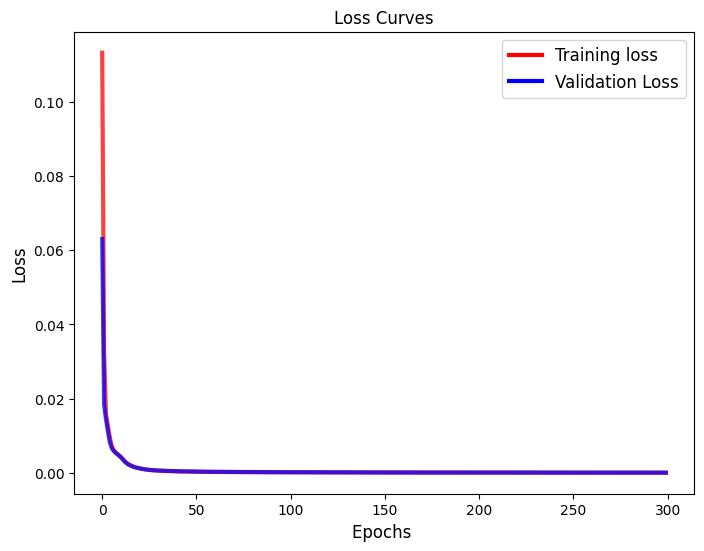

In [546]:
# Luodaan käyrä menetyksien määrän kehityksestä jokaisella Epochilla
create_loss_curves(history)

In [547]:
# Poimitaan encoder malli koulututetusta autoencoderista
encoder_model = Sequential()
encoder_model.add(autoencoder_model.layers[0])
encoder_model.add(autoencoder_model.layers[1])

In [548]:
# luokitellaan encoderin avulla
encoded_features_train = encoder_model.predict(X_train)
encoded_features_test = encoder_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [549]:
# Luodaan luokittelumalli lisäämällä luokittelutaso
classification_model = Sequential()
classification_model.add(Dense(1, activation='sigmoid', input_dim=encoded_features_train.shape[1]))
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [550]:
# Koulutetaan luokittelumalli
classification_history = classification_model.fit(encoded_features_train, 
                                                  y_train, epochs=300, 
                                                  batch_size=500, 
                                                  validation_data=(encoded_features_test, y_test))

Epoch 1/300
20/20 [==============================] - 1s 13ms/step - loss: 0.6688 - accuracy: 0.5481 - val_loss: 0.6624 - val_accuracy: 0.5523
Epoch 2/300
20/20 [==============================] - 0s 4ms/step - loss: 0.6531 - accuracy: 0.6169 - val_loss: 0.6470 - val_accuracy: 0.6269
Epoch 3/300
20/20 [==============================] - 0s 5ms/step - loss: 0.6381 - accuracy: 0.6961 - val_loss: 0.6327 - val_accuracy: 0.8059
Epoch 4/300
20/20 [==============================] - 0s 5ms/step - loss: 0.6244 - accuracy: 0.8164 - val_loss: 0.6191 - val_accuracy: 0.8145
Epoch 5/300
20/20 [==============================] - 0s 5ms/step - loss: 0.6114 - accuracy: 0.8211 - val_loss: 0.6064 - val_accuracy: 0.8244
Epoch 6/300
20/20 [==============================] - 0s 5ms/step - loss: 0.5992 - accuracy: 0.8538 - val_loss: 0.5943 - val_accuracy: 0.8565
Epoch 7/300
20/20 [==============================] - 0s 5ms/step - loss: 0.5876 - accuracy: 0.8817 - val_loss: 0.5830 - val_accuracy: 0.8911
Epoch 8/300


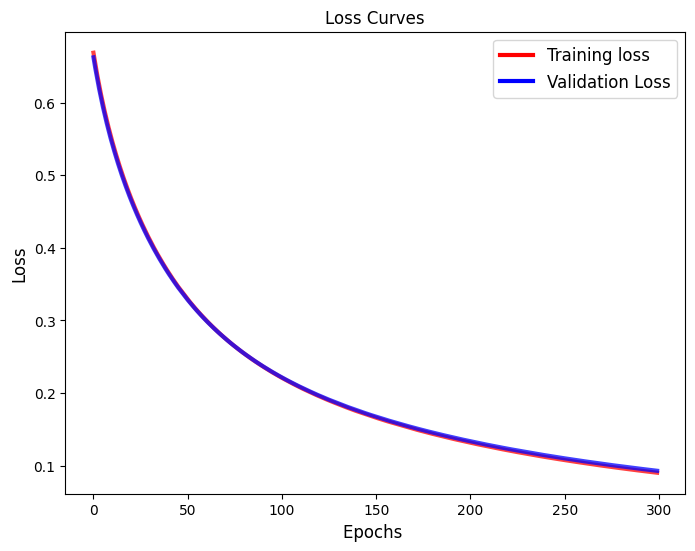

In [551]:
# Luodaan käyrä menetyksien määrän kehityksestä jokaisella Epochilla
create_loss_curves(classification_history)

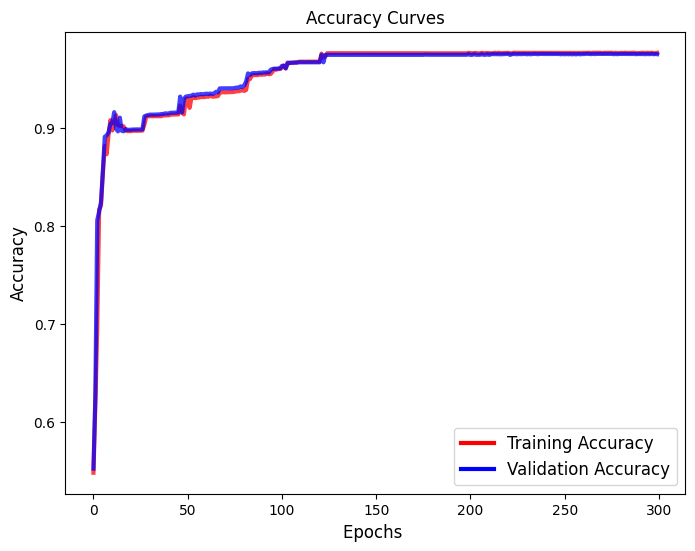

In [552]:
# Luodaan käyrä tarkkuuden kehityksestä jokaisella Epochilla
create_accuracy_curves(classification_history)

In [553]:
# Arvioidaan luokittelumalli testidatan avulla
loss, accuracy = classification_model.evaluate(encoded_features_test, y_test)
print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")

313/313 [==============================] - 1s 1ms/step - loss: 0.0929 - accuracy: 0.9754
Accuracy on Test Set: 97.54%


In [554]:
# Ennustetaan luokittelumallin avulla
result_prob = classification_model.predict(encoded_features_test)
result = (result_prob > 0.5).astype(int) 

313/313 [==============================] - 0s 1ms/step


Confusion Matrix:


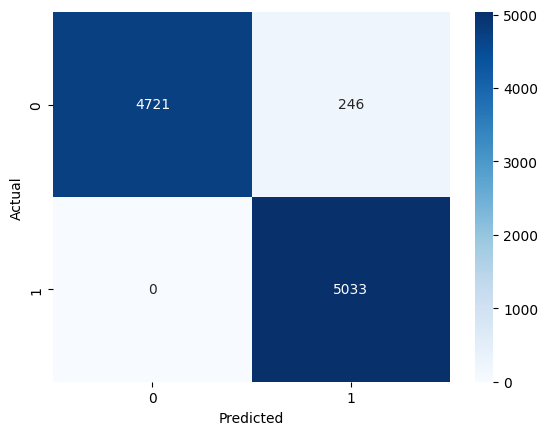

In [557]:
# Luodaan sekaannusmatriisi (confusion matrix) tuloksista
create_confusion_matrix(y_test, result)

In [558]:
# Lasketaan precision_score, recall_score, ja f1_score
calculate_results(y_test, result)

Precision: 0.953400
Recall: 1.000000
F1 Score: 0.998693


# Yhteenveto

yhteenveto 

# Lähteet:

In [ ]:
Ahmed, S., Khan, Z. A., Mohsin, S. M., Latif, S., Aslam, S., Mujlid, H., . . . Najam, Z. 2023. 
Effective and Efficient DDoS Attack Detection Using Deep Learning Algorithm, Multi-Layer Perceptron. 
Future internet, 15(2), p. 76. doi:10.3390/fi15020076

